# TFSAX-style Symbolic Encoding of Time Series (SAX + Trend)

This notebook demonstrates a simple pipeline that maps a univariate time series \(T = (t_1, \dots, t_N)\) to:

- A SAX word capturing mean behavior per segment.
- A trend word capturing simple up/down/flat movement per segment.
- A combined numeric feature matrix \(X\) with shape `(segments, features)` suitable for feeding into sequence models later on.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)


## Synthetic time series

We generate a short example series that combines a linear trend, two sinusoidal components, and Gaussian noise. This keeps the demo reproducible and self-contained.


First 10 values of the synthetic time series:
[0.15 0.24 0.69 1.05 0.48 0.36 0.76 0.41 0.02 0.38]


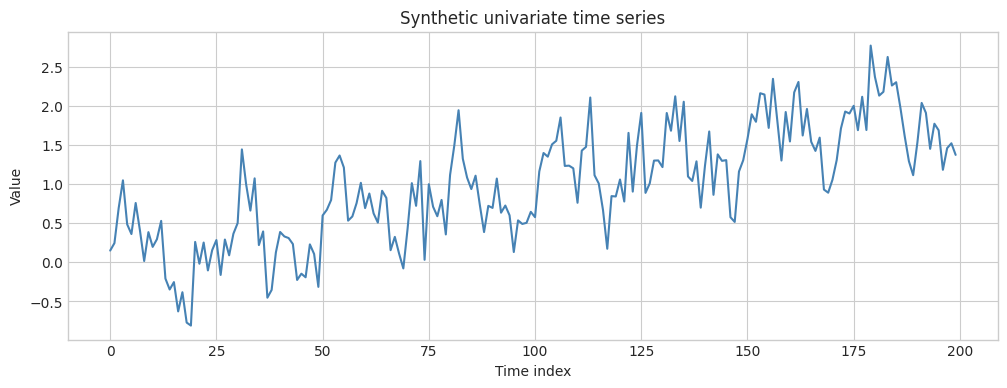

In [2]:
N = 200
indices = np.arange(N)

trend_component = 0.01 * indices
seasonal_component = 0.4 * np.sin(2 * np.pi * indices / 25) + 0.3 * np.sin(2 * np.pi * indices / 10)
noise_component = np.random.normal(loc=0.0, scale=0.3, size=N)

T = trend_component + seasonal_component + noise_component
print("First 10 values of the synthetic time series:")
print(np.round(T[:10], 2))

fig, ax = plt.subplots()
ax.plot(indices, T, color="steelblue")
ax.set_title("Synthetic univariate time series")
ax.set_xlabel("Time index")
ax.set_ylabel("Value")
ax.grid(True)
plt.show()


## PAA Transformation

In [3]:
from pyts.approximation import PiecewiseAggregateApproximation

window_size = 20
paa = PiecewiseAggregateApproximation(window_size=window_size)
T_paa = paa.fit_transform(T.reshape(1, -1))
print("\nPAA representation (window size = {}):".format(window_size))
# print average of first 10 values of T
print(np.round(np.mean(T[:20]), 2))

print(np.round(T_paa[0], 2))



PAA representation (window size = 20):
0.11
[0.11 0.3  0.48 0.59 0.84 1.17 1.35 1.5  1.71 1.79]


## Trend of PAA Segment
Determine the trend of each PAA segment by comparing its last value to its first value, with a small threshold buffer

In [4]:

threshold = 0.1
num_segments = T_paa.shape[1]
print("\nNumber of PAA segments:", num_segments)
trend_directions = []
for i in range(num_segments):
    start_idx = i * window_size
    end_idx = min((i + 1) * window_size, len(T))
    segment = T[start_idx:end_idx]
    trend = segment[-1] - segment[0]
    if trend > threshold:
        trend_directions.append(1)  # up
    elif trend < -threshold:
        trend_directions.append(-1)  # down
    else:
        trend_directions.append(0)  # flat
print("\nTrend directions for each PAA segment (1=up, 0=flat, -1=down):")
print(trend_directions)


Number of PAA segments: 10

Trend directions for each PAA segment (1=up, 0=flat, -1=down):
[-1, -1, 1, -1, -1, 1, -1, 1, 1, -1]


## Perfrom SAX on PAA Segments

In [68]:
from pyts.approximation import SymbolicAggregateApproximation

paa_sax = SymbolicAggregateApproximation(n_bins=5, strategy='quantile')
T_paa_sax = paa_sax.fit_transform(T_paa)
print("\nSAX representation of PAA segments:")
print(T_paa_sax[0])



SAX representation of PAA segments:
['a' 'a' 'b' 'b' 'c' 'c' 'd' 'd' 'e' 'e']


## Combine SAX and Trend Features

In [69]:
# list of combined features
combined_features = []
for sax_symbol, trend in zip(T_paa_sax[0], trend_directions):
    combined_features.append((sax_symbol, trend))
print("\nCombined SAX and trend features for each PAA segment:")
# pretty print combined features
for i, (sax_symbol, trend) in enumerate(combined_features):
    print("Segment {}: SAX symbol = {}, Trend = {}".format(i, sax_symbol, trend))
    


Combined SAX and trend features for each PAA segment:
Segment 0: SAX symbol = a, Trend = -1
Segment 1: SAX symbol = a, Trend = 1
Segment 2: SAX symbol = b, Trend = 1
Segment 3: SAX symbol = b, Trend = 1
Segment 4: SAX symbol = c, Trend = -1
Segment 5: SAX symbol = c, Trend = -1
Segment 6: SAX symbol = d, Trend = -1
Segment 7: SAX symbol = d, Trend = 1
Segment 8: SAX symbol = e, Trend = 1
Segment 9: SAX symbol = e, Trend = -1
